#  Sentiment Analysis via the ML-based approach


In [1]:
#Importing the libraries needed
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import string
import unicodedata
import textstat
import unidecode

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from bs4 import BeautifulSoup

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_auc_score

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings; warnings.simplefilter('ignore')

In [2]:
#importing the training and test datasetses
#check the number of instances in each dataset and check if there are missing valu

df_train = pd.read_csv("sentiment_train.csv")
print(df_train.info())
print(df_train.head(3))

df_test = pd.read_csv("sentiment_test.csv")
print(df_train.info())
print(df_train.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                    Sentence  Polarity
0                   Wow... Loved this place.         1
1                         Crust is not good.         0
2  Not tasty and the texture was just nasty.         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                    Sentence  Polarity
0                   Wow... Loved this place.         1
1                         Crust is not goo

<AxesSubplot:xlabel='Polarity', ylabel='count'>

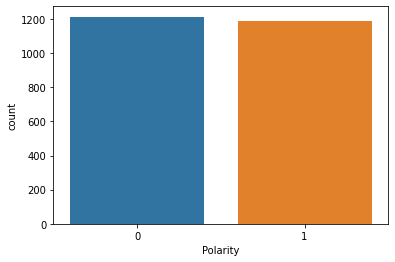

In [3]:
#the countplot implies that the training dataset is not imbalanced 
sns.countplot(df_train['Polarity'])

<AxesSubplot:xlabel='Polarity', ylabel='count'>

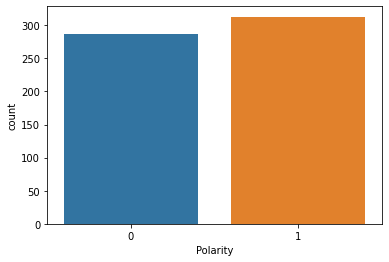

In [4]:
#the countplot implies that the testing dataset is not imbalanced 
sns.countplot(df_test['Polarity'])

### Part 1.b. Modeling


In [5]:
# To extract features out from the training and testing datasets
# Transformed them to datasets for future procedure
X_train = df_train['Sentence'].to_frame()
X_test = df_test['Sentence'].to_frame()

## To extract labels out from the training and testing datasets
y_train = df_train['Polarity']
y_test = df_test['Polarity']

In [6]:
#Since the dataset has only one feature, which is text, I mainly tested to use some of the NLP techiniques to transform this feature.

In [7]:
# To build a process function to transform the text feature, including make all words lowercase, as well as remove URL, punctuation, numbers and lemmatize words.

#After testing a few machine learning models, it was observed that remove stopwords will not imporve model performances, thus stopwords were not removed on purpose.

lemmer = WordNetLemmatizer()

def my_preprocess(doc):
    
    # Lowercase
    doc = doc.lower()
    
    # Remove URLs
    doc = re.sub(r'http\S+', '', doc)
    
    #Remove punctuation
    doc = re.sub(r'[^\w\s]', '', doc)
    
    #Remove numbers 
    doc = re.sub(r'\d+', '', doc)
    
    # lemmatize
    doc = [lemmer.lemmatize(w) for w in doc.split()]
    
    return ' '.join(doc) 

In [8]:
#To set up functions to perform TF-IDF on the text feature

vectorizer = TfidfVectorizer(preprocessor=my_preprocess,
                             max_df = 0.9, 
                             min_df=0.01, 
                             max_features = 1000, 
                             ngram_range=[1,3])
text_feature = 'Sentence'
drop_features = ['Sentence']

def fit_features(df):
  global dtm
  dtm = vectorizer.fit(df[text_feature])

  return

def transform_features(df):
  global dtm
 
  if dtm is None:
    print("Need to call fit_features first!")
    return

  dtm = vectorizer.transform(df[text_feature])

  features = pd.DataFrame(dtm.toarray(), 
                      columns=['bow_{:s}'.format(name) for name in 
                               vectorizer.get_feature_names()], 
                      index=df.index)
  
  passthrough_features = [c for c in df.columns if c not in drop_features]
  
  features[passthrough_features] = df[passthrough_features]

  features['len'] = df['Sentence'].apply(lambda x: len(x))
  features['syllable_count'] = df['Sentence'].apply(
        lambda x: textstat.syllable_count(x))
  features['flesch_reading_ease'] = df['Sentence'].apply(
      lambda x: textstat.flesch_reading_ease(x))
  
  return features

In [9]:
# To use the training text feature to fit the TF-IDF function,then use the fitted function to transfer the training text feature and testing feature.
# Transformed training text features will be used to train the model, and transformed testing text features will be used to access model performance.

fit_features(X_train)
X_train_features = transform_features(X_train)
X_test_features = transform_features(X_test)

In [10]:
# Tested decision tree, random forest, KNN and XGBoost models and it turns out XGBoost has the best proformance

clf_xg = XGBClassifier(n_estimators=100, max_depth=3)

clf_xg.fit(X_train_features, y_train)

y_pred_xg = clf_xg.predict(X_test_features)

print("AUC = {:.5f}".format(roc_auc_score(y_test, y_pred_xg)))


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

AUC = 0.65557


In [11]:
#Conduct Grid Sarch on XGBoost model to get hyperparameters that will build a better model
xg = XGBClassifier()

params = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],
      'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'max_depth': [1, 10, 20]}

gridsearch = GridSearchCV(xg, params, scoring='roc_auc', cv=5, return_train_score=True)

%time gridsearch.fit(X_train_features, y_train)

CPU times: user 2h 2min 26s, sys: 35.3 s, total: 2h 3min 1s
Wall time: 33min 4s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,
  

In [12]:
#get the best hypermeters from the hyperparameter tunning 
gridsearch.best_params_
gridsearch.best_score_
gridsearch.best_estimator_

{'colsample_bytree': 1.0,
 'gamma': 1,
 'max_depth': 20,
 'min_child_weight': 1,
 'subsample': 1.0}

0.804922689866945

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [13]:
#Re-run the XGBoost model with hyperparameters from the hypermeters tunning process 
#Compute the AUC score to compare with the previous model and it turns out that grid search hyperparameter tunning didn't improve model proformance

clf_xg2 = XGBClassifier(colsample_bytree =1.0, gamma =1, max_depth=20, min_child_weight=1,subsample=1)


clf_xg2.fit(X_train_features, y_train)

y_pred_xg2 = clf_xg2.predict(X_test_features)


print("AUC = {:.5f}".format(roc_auc_score(y_test, y_pred_xg2)))



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

AUC = 0.64410


### Part 1.c. Assessing

Use the testing data to measure the accuracy and F1-score.  

In [14]:
y_pred_xg = clf_xg.predict(X_test_features)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_xg))

print("\nF1 Micro Score = {:.5f}".format(f1_score(y_test, y_pred_xg, average="micro")))
print("\nF1 Macro Score = {:.5f}".format(f1_score(y_test, y_pred_xg, average="macro")))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xg))

print("AUC = {:.5f}".format(roc_auc_score(y_test, y_pred_xg)))


Confusion matrix:
[[214  73]
 [136 177]]

F1 Micro Score = 0.65167

F1 Macro Score = 0.65034

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       287
           1       0.71      0.57      0.63       313

    accuracy                           0.65       600
   macro avg       0.66      0.66      0.65       600
weighted avg       0.66      0.65      0.65       600

AUC = 0.65557


### Part 3. Show five example instances in which your model’s predictions were incorrect. Describe why you think the model was wrong.

In [15]:
#Five of the wrong predictions are listed below:

pd.set_option('display.max_colwidth', -1)
df_test['Predict'] = y_pred_xg
df_test['Sentence_processed'] = df_test['Sentence'].apply(my_preprocess)
df_test[df_test['Predict'] != df_test['Polarity']].head(5)

,Sentence,Polarity,Predict,Sentence_processed
4,It has northern humour and positive about the community it represents.,1,0,it ha northern humour and positive about the community it represents
5,I rather enjoyed it.,1,0,i rather enjoyed it
6,I liked it.,1,0,i liked it
8,It really created a unique feeling though.,1,0,it really created a unique feeling though
10,A world better than 95% of the garbage in the theatres today.,1,0,a world better than of the garbage in the theatre today


#### Potential Reasons of Incorrect Predictions

The first five wrong predictions are listed above in line 15. Comparing with the first ten correct predictions, which are listed below in line 16, one of the patterns can be observed is that the incorrectly predicted instances are more likely to have a general 'Sentence". For example, sentences of "I liked it" and "I enjoyed it" are like high-level summary, they are only stating whether or not the movie is good without much explanation. Differently, the correctly predicted instances are more likely to include some explanations in the sentences, such as the role was played well, or the scripts were written well. Having more explanations can give the machine learning model more inputs to assess and predict. 

The other reasons might be that the training dataset and testing dataset are having different set of commonly used words. As presented in line 18 and line 19, the top-ten frequently used words in training dataset are “good”, “great” “phone”, “food”, “place”, “service”, “time”, “work”, “one”, and “like”; whereas the top-ten frequently used words in testing dataset are “film”, “movie” “one”, “bad”, “like”, “character”, “good”, “time”, “acting”, and “great”. Five words appear in both training and testing datasets when looking at top-ten frequently used words. Moreover, no word appears in both testing and training datasets when looking at top-five frequently used words. This situation could lead to that the model is performing well on training dataset but not performing well on testing dataset.  







#### Supporting code and outputs for Part 3

In [16]:
df_test[df_test['Predict'] == df_test['Polarity']].head(5)

,Sentence,Polarity,Predict,Sentence_processed
0,A good commentary of today's love and undoubtedly a film worth seeing.,1,1,a good commentary of today love and undoubtedly a film worth seeing
1,"For people who are first timers in film making, I think they did an excellent job!!",1,1,for people who are first timer in film making i think they did an excellent job
2,"It was very popular when I was in the cinema, a good house and very good reactions and plenty of laughs.",1,1,it wa very popular when i wa in the cinema a good house and very good reaction and plenty of laugh
3,It's a feel-good film and that's how I felt when I came out of the cinema!,1,1,it a feelgood film and thats how i felt when i came out of the cinema
7,I couldn't take them seriously.,0,0,i couldnt take them seriously


In [17]:
# To develop a new preprocess function that is similiar than the previous but add removing stopwords

stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

lemmer = WordNetLemmatizer()

def preprocess2(x):
    # Remove HTML tags
    x = BeautifulSoup(x, "lxml").get_text()

    # Lower case
    x = x.lower()
    
    # Remove punctuation
    x = re.sub(r'[^\w\s]', '', x)
    
    # Remove non-unicode
    x = unidecode.unidecode(x)
    
    # Remove numbers
    x = re.sub(r'\d+', '', x)
    
    # Remove stopwords and lemmatize
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x) 

train_sentence = df_train['Sentence'].apply(preprocess2)

In [18]:
#To present the top ten 1-grams for the training dataset
no_features = 1000

tf_vectorizer = CountVectorizer(min_df=.01, max_df=.9, max_features=no_features, ngram_range=[1,3])
%time dtm_tf = tf_vectorizer.fit_transform(train_sentence)

##Calculate column sums from DTM and sort them
sum_words = dtm_tf.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tf_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

##Display top ten
words_freq[:10]


CPU times: user 64.8 ms, sys: 5.71 ms, total: 70.5 ms
Wall time: 69.6 ms


[('good', 194),
 ('great', 181),
 ('phone', 174),
 ('food', 124),
 ('place', 117),
 ('service', 107),
 ('time', 99),
 ('work', 98),
 ('one', 95),
 ('like', 92)]

In [19]:
#To present the top ten 1-grams for the testing dataset

test_sentence = df_test['Sentence'].apply(preprocess2)
tf_vectorizer = CountVectorizer(min_df=.01, max_df=.9, max_features=no_features, ngram_range=[1,3])
%time dtm_tf = tf_vectorizer.fit_transform(test_sentence)

##Calculate column sums from DTM and sort them
sum_words = dtm_tf.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tf_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

## Display top ten
words_freq[:10]

CPU times: user 20.6 ms, sys: 231 µs, total: 20.8 ms
Wall time: 20.8 ms


[('film', 124),
 ('movie', 119),
 ('one', 52),
 ('bad', 47),
 ('like', 35),
 ('character', 34),
 ('good', 33),
 ('time', 33),
 ('acting', 30),
 ('great', 26)]